Итоговый проект по курсу "Data science", автор - Швая Тимофей, BAE'25

В данном проекте я провожу анализ рынка аренды недвижимости в Москве и Подмосковье. Я постараюсь построить простую ML-модель для предсказания цены аренды квартиры, а также проанализирую полученные данные. Поскольку большинство крупных площадок для размещения объявоений предоставляют доступ к своим API на платной основе, сбор данных проводится с помощью дата-скрейпинга с Авито. Чтобы минимизировать вероятность бана(а сооотвественно и неисполнения кода), используется бибилиотека Selenium которая эмултирует действия реального пользователя. Данный подходит позволил мне успешно собирать необходимую информацию, однако он требует большего времени на исполнение. Начнем проект с подгрузки необходимых бибилиотек.

In [49]:
import selenium
import requests
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException


Далее идет код парсера, подробнее в комментариях в коде.

In [59]:
#Данная функция использует регулярные выражения для обработки информации извелченной с html-страницы объявления.
def extract_attributes(string):
    pattern = r'(.+?):\s?([^:\n]+)'
    matches = re.findall(pattern, string)
    result = {}
    
    for attribute, value in matches:
        result[attribute] = value
    
    all_attributes = {'Тип дома', 'Год постройки', 'Этажей в доме', 'Пассажирский лифт', 'Грузовой лифт', 'Парковка'}
    
    for attribute in all_attributes:
        if attribute not in result:
            result[attribute] = None
    
    return result

#Данная функция дублирует функционал предыдущий и отличается лишь типом подаваемой строки - тут я извлекаю другие аттрибуты.
def extract_more_attributes(string):
    pattern = r'(.+?):\s?([^:\n]+)'
    matches = re.findall(pattern, string)
    result = {}
    
    for attribute, value in matches:
        result[attribute] = value
    
    all_attributes = {'Количество комнат', 'Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж', 'Балкон или лоджия',
                     'Санузел', 'Ремонт', 'Мебель', 'Техника', 'Интернет и ТВ', 'Количество гостей', 'Можно с детьми', 
                      'Можно с животными', 'Можно курить'}

    for attribute in all_attributes:
        if attribute not in result:
            result[attribute] = None
    
    return result

#Данная функция предназначена для получения информации о времени, затрачиваемом для перемещения на машине между двух точек. На вход подаются координаты первой и второй точек.
def time_to_travel(coordinates1, coordinates2):
    
    string = "https://api.openrouteservice.org/v2/directions/driving-car?api_key=" + api_key + "&start=" + coordinates1 + "&end=" + coordinates2
    
    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    }
    response = requests.get(string, headers=headers)

    duration_minutes = 0
    
    if response.status_code == 200:
        #Поскольку api openrouteservice не имеет функционала возврата врмеени маршрута по умолчанию, я использую недокументированные возможности api извлекая информацию о времери из json-файла ответа.
        data = response.json()
        duration = data['features'][0]['properties']['segments'][0]['duration']
        duration_minutes = round(duration // 60)
        
    return(duration_minutes)

#Далее я определяю некоторые переменные необходимые для парсинга. В том числе тут приведен мой api-ключ от сервиса openrouteservice. Он предоставляет до 2000 запросов в течении 24 часов.

columns = ["Местоположение", "Комнат", "Общая площадь", "Площадь кухни", "Жилая площадь", "Этаж", "Цена", "Тип дома", "Год постройки", "Этажей в доме", "Пассажирский лифт", "Грузовой лифт", "Парковка", "Балкон", "Санузел", "Ремонт", "Интернет и ТВ", "Можно с детьми", "Можно с животными", "Можно курить", "Координаты"]
data = []

df = pd.DataFrame(data, columns=columns)

api_key = "5b3ce3597851110001cf6248ca34dc949cd04ef794b91b8f12f5cbd6"

# Установка пути к драйверу Chrome, если будуете запускать данную часть - необходимо поменять путь к драйверу.
driver_path = '/Users/tim17/Downloads/chromedriver_mac_arm64/chromedriver'

# Опции Chrome, браузер запускаем в фоновом режиме.
chrome_options = Options()
chrome_options.add_argument("--headless") 

service = Service(driver_path)
driver = webdriver.Chrome(service=service, options=chrome_options)


# Данная ыункция предназначена для извлечения данных из одного объявления.
def process_ad(ad):
    #В первой части работаем с кратким описанием объявления
    
    #Извлекаем информацию о местоположении таким нетрививальным способом, посокльку она содержится в кратком описании обхъявления и не имеет собственного css-селектора.
    location = ad.find_element(by=By.CSS_SELECTOR, value='div[data-marker="item-address"]').text.strip().split("\n")[0]
    
    params = ad.text.split("\n")
    
    # Аналогично мзвлекаем и информацию о цене.
    price = int(params[1].split()[0])*1000+ int(params[1].split()[1])
    
    element = ad.find_element(by=By.CSS_SELECTOR, value='a[data-marker="item-title"]')
    url = element.get_attribute("href")
    
    #Работа с объявлением
    #Запускаем дополнительный драйвер (окно браузера), поскольку далее мы открываем само объявление и извлекаем дополнительные параметры квартиры.
    new_driver.get(url)

    new_driver.implicitly_wait(2)
    
    info = new_driver.find_element(by=By.CSS_SELECTOR, value = '#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div.style-item-view-block-SEFaY.style-item-view-house-params-NgkiB.style-new-style-iX7zV > div > ul').text.strip()
    
    #Структура таблицы отличается в зависимости от наличия или отсутствия фотографй и онлайн-показа. Поэтому использована конструкция try-exept.
    try:
        element = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(1) > div > ul')
        info_more_1 = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(1) > div > ul').text.strip()
        info_more_2 = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(2) > div > ul').text.strip()

        info_more = info_more_1 + "\n" + info_more_2

    except NoSuchElementException:
        try:
            element = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(2) > div > ul')
            info_more_1 = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(2) > div > ul').text.strip()
            info_more_2 = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(3) > div > ul').text.strip()

            info_more = info_more_1 + "\n" + info_more_2

        except NoSuchElementException:
            info_more_1 = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(3) > div > ul').text.strip()
            info_more_2 = new_driver.find_element(by=By.CSS_SELECTOR, value='#app > div > div.index-root-k1Ib4.index-responsive-aOpFS.index-page_default-_b5bD > div:nth-child(1) > div > div.style-item-view-PCYlM > div.style-item-view-content-SDgKX > div.style-item-view-content-left-bb5Ih > div.style-item-view-main-tKI1S.js-item-view-main.style-item-min-height-TJwyJ > div:nth-child(1) > div:nth-child(4) > div > ul').text.strip()

            info_more = info_more_1 + "\n" + info_more_2
            
    #После извлечения подробной информации, обрабатываем ее с помощью функций описанных ранее.
    
    attributes = {**extract_attributes(info), **extract_more_attributes(info_more)}

    house_type = attributes["Тип дома"]

    if attributes["Год постройки"] is not None:
        year_built = int(attributes["Год постройки"])
    else:
        year_built = None

    if attributes["Этажей в доме"] is not None:
        floors = int(attributes["Этажей в доме"])
    else:
        floors = None


    if(attributes["Пассажирский лифт"] == "нет") or attributes["Пассажирский лифт"] is None:
        passenger_elevators_num = None
    else:
        passenger_elevators_num = int(attributes["Пассажирский лифт"])

    if(attributes["Грузовой лифт"] == "нет") or attributes["Грузовой лифт"] is None:
        service_elevators_num = None
    else:
        service_elevators_num = int(attributes["Грузовой лифт"])

    parking_type = attributes["Парковка"]

    rooms = attributes["Количество комнат"]

    #Поскольку хотим чтобы количество комнат было переменной типа int, переназначаем параметр комнат для студий.
    if rooms == "Студия" or rooms == "студия":
        rooms = 0.5
    elif rooms == "10 комнат и больше":
        rooms = 11
    elif rooms == "Своб. планировка":
        rooms = 0
    else:
        rooms = int(rooms)

    area = float(attributes["Общая площадь"].split()[0])

    if attributes["Площадь кухни"] is not None:
        kitchen_area = float(attributes["Площадь кухни"].split()[0])
    else:
        kitchen_area = None

    if attributes["Жилая площадь"] is not None:
        living_area = float(attributes["Жилая площадь"].split()[0])
    else:
        living_area = None

    floor = int(attributes["Этаж"].split()[0])

    balcony = attributes["Балкон или лоджия"]

    toilet = attributes["Санузел"]

    renovation = attributes["Ремонт"]

    internet = attributes["Интернет и ТВ"]

    kids_allowed = (attributes["Можно с детьми"] == "да")

    pets_allowed = (attributes["Можно с животными"] == "да")

    smoking_allowed = (attributes["Можно курить"] == "да")

    #Узнаем координаты квартиры. Иногда api не знает введенный адрес, тогда пытаемся найти координаты объектов близких к нашему адресу(постепенно удаляем информацию - сперва о корпусе/строении, потом о доме, улице и так далее - пока не сможем получить координаты)
    parametrs_for_openstreetmap = {
    "q": location,
    "format": "json",
    "limit": 1
    }

    response = requests.get("https://nominatim.openstreetmap.org/search", params=parametrs_for_openstreetmap)

    correct_coordinates = False

    lat = 0
    lon = 0

    if response.status_code == 200:
        data = response.json()
        if len(data) > 0:
            lat = data[0]["lat"]
            lon = data[0]["lon"]
            correct_coordinates = True
        else:
            while(len(location) > 0) and not correct_coordinates:
                location = location[:-1]
                parametrs_for_openstreetmap = {
                    "q": location,
                    "format": "json",
                    "limit": 1
                    }

                response = requests.get("https://nominatim.openstreetmap.org/search", params=parametrs_for_openstreetmap)
                if response.status_code == 200:
                    data = response.json()
                    if len(data) > 0:
                        lat = data[0]["lat"]
                        lon = data[0]["lon"]
                        correct_coordinates = True


    coordinates = str(lon) + "," + str(lat)


    #Добавляем полученную информацию в глобальную переменную датафрейма.
    row = [location, rooms, area, kitchen_area, living_area, floor, price, house_type, year_built, floors, passenger_elevators_num, service_elevators_num, parking_type, balcony, toilet, renovation, internet, kids_allowed, pets_allowed, smoking_allowed, coordinates]
    df.loc[len(df)] = row
    if (len(df) % 20 == 0):
        print("Number of rows in df: ", len(df))


    
new_driver = webdriver.Chrome(service=service, options=chrome_options)

# URL страницы с объявлениями недвижимости на Avito
url = 'https://www.avito.ru/moskva/kvartiry/sdam/na_dlitelnyy_srok?p='

advertisements = []

#Параметр num_pages отвечает за количество спарсенных страниц. Чем больше параметр, тем качественнее дальнейшие выводы и модели. Однако возрастает и время парсинга.
num_pages = 3

for page in range(1, num_pages + 1):
    print("Parsing page number", page)
    url_new = url + str(page)
    
    driver.get(url_new)

    driver.implicitly_wait(10)

    advertisements = driver.find_elements(by=By.CSS_SELECTOR, value='div[data-marker="item"]')
    for ad in advertisements:
        process_ad(ad)


# Закрываем веб-драйвер после завершения парсинга, чтобы не расходовать ОЗУ зря.
driver.quit()
new_driver.quit()

Parsing page number 1
Number of rows in df:  20
Number of rows in df:  40
Parsing page number 2
Number of rows in df:  60
Number of rows in df:  80
Number of rows in df:  100
Parsing page number 3
Number of rows in df:  120
Number of rows in df:  140


Чтобы в дальнейшем у нас была возможность возвращаться к исходному датафрейму, скопируем его. Далее в уже новом датафрейме создадим переменные координат (это облегчит выполнение ряда действий в дальнейшем) и используя определенную в первой ячейке функцию, найдем время необходимое на перемещение между квартирой и центром Москвы. Время до центра будем использовать как один из параметпров модели предсказания цен.

In [60]:
df_to_work = df.copy()

df_to_work["долгота"] = df_to_work["Координаты"].apply(lambda x: float(x.split(",")[0]))
df_to_work["широта"] = df_to_work["Координаты"].apply(lambda x: float(x.split(",")[1]))
#Оставляю для анализа только объявления из Москвы и ближнего Подмосковья (не нашел на авито фильтр для ближнего Подмосковья, так что в датасет попали и квартиры из городов далеко от Москвы).
df_to_work = df_to_work[(36.5 < df_to_work['долгота']) & (df_to_work['долгота'] < 38.5) & (55 < df_to_work['широта']) & (df_to_work['широта'] < 56.5)]
coordinates_kremlin = "37.6167,55.75"
df_to_work["Время до центра"] = df_to_work["Координаты"].apply(lambda x: time_to_travel(x, coordinates_kremlin))


Взглянем на полученные данные на карте Москвы.

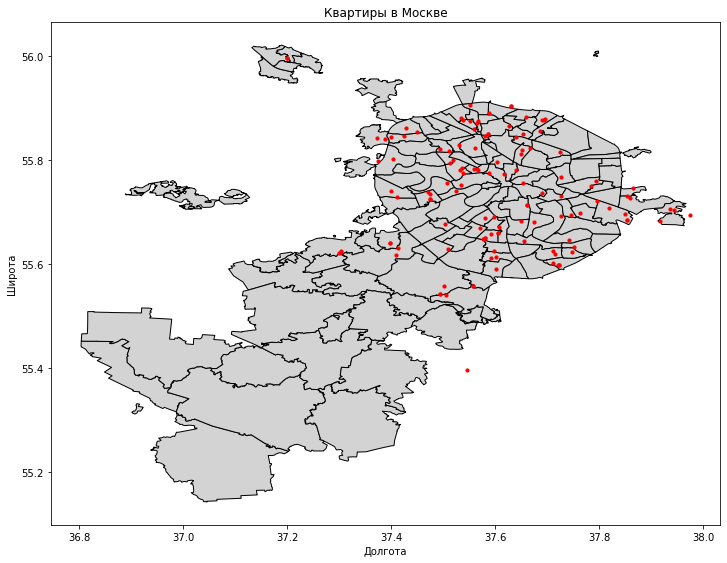

In [61]:
# Загрузка данных о границах Москвы, ссылка взята с одного из семинаров.
adm_moscow = gpd.read_file("http://gis-lab.info/data/mos-adm/mo.geojson")
df_2 = df_to_work.copy()

gdf_flats = gpd.GeoDataFrame(df_2, geometry=gpd.points_from_xy(df_2["долгота"], df_2["широта"]))

fig, ax = plt.subplots(figsize=(12, 12))

# Отображение границ Москвы
adm_moscow.plot(ax=ax, color="lightgray", edgecolor="black")

# Отображение точек-квартир
gdf_flats.plot(ax=ax, color="red", markersize=10)

plt.title("Квартиры в Москве")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

Последним этапом подготовки данных будет классификация квартир по Районам.

Затем построим несложную предсказательную модель на основе случайного леса. Чтобы чуть улучшить результаты нашей модели, используем тюнинг параметров с помощью заданной сетки.

In [62]:
df_1 = df_to_work.copy()
df_1 = df_1.drop(['Местоположение', 'Координаты'], axis=1)

url = "http://gis-lab.info/data/mos-adm/mo.geojson"
response = requests.get(url)
mo_geojson = response.json()

adm_moscow = gpd.GeoDataFrame.from_features(mo_geojson["features"])

# Создание GeoDataFrame на основе данных о квартирах с координатами
gdf = gpd.GeoDataFrame(df_1, geometry=gpd.points_from_xy(df_1['долгота'], df_1['широта']))

merged = gpd.sjoin(gdf, adm_moscow, op='within')

df_1['Район'] = merged['NAME']

#Для кодирования категориальных фич используем One-Hot Encoding
df_1 = df_1.drop(['широта', 'долгота'], axis=1)
categorical_features = ['Тип дома', 'Парковка', 'Балкон', 'Санузел', 'Ремонт', 'Интернет и ТВ', 'Район']
df_1 = pd.get_dummies(df_1, columns=categorical_features, drop_first=True)
df_1['Грузовой лифт'] = df_1['Грузовой лифт'].fillna(0)
df_1['Пассажирский лифт'] = df_1['Пассажирский лифт'].fillna(0)
df_1 = df_1.fillna(df_1.mean())

X = df_1.drop('Цена', axis=1)
y = df_1['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE на тестовом наборе:", rmse)

/Users/tim17/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RMSE на тестовом наборе: 26684.286093142866


Точность модели весьма низкая - я постараюсь решить эту проблему чуть дальше в своем проекте. А пока посмотрим на полученные данные.
Сперва посомтрим на то, какие "фичи" - параметры квартиры, наиболее влияют на цену аренды. Поскольку по абсолютным значениям значимость фичей кроме общей площади и количества комнат близки, чтобы они не сливались в один цвет, использую логарифмическую шкалу. Для визуализации используя граф зависимостей, где за важность отвечает цвет ребра (чем темнее - тем важнее).

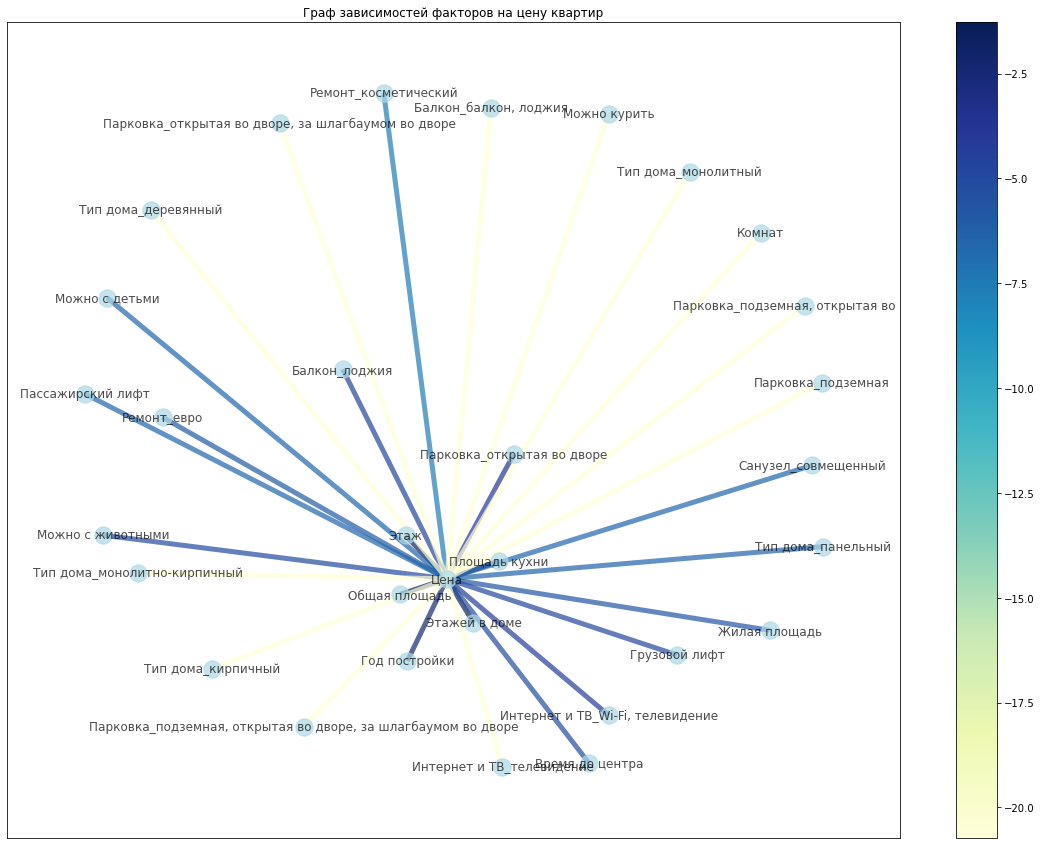

In [63]:
dependency_graph = nx.Graph()

factors = feature_importance_df['Feature']
dependency_graph.add_nodes_from(factors)

dependencies = [(row['Feature'], 'Цена', {'weight': row['Importance']}) for index, row in feature_importance_df.iterrows()]
dependency_graph.add_edges_from(dependencies)

plt.figure(figsize=(20, 15))
pos = nx.spring_layout(dependency_graph)
edge_colors = [dependency_graph[u][v]['weight'] for u, v in dependency_graph.edges()]
edge_colors = np.log(np.array(edge_colors) + 1e-9)
nx.draw_networkx(dependency_graph, pos, with_labels=True, node_color='lightblue', edge_cmap=plt.cm.YlGnBu, edge_color=edge_colors, alpha=0.7, width = 5)
plt.title('Граф зависимостей факторов на цену квартир')

sm = plt.cm.ScalarMappable(cmap=plt.cm.YlGnBu)
sm.set_array(edge_colors)
plt.colorbar(sm)
plt.show()

Еще построим график зависимости цены аренды от площади, дополнительно выводя тип дома

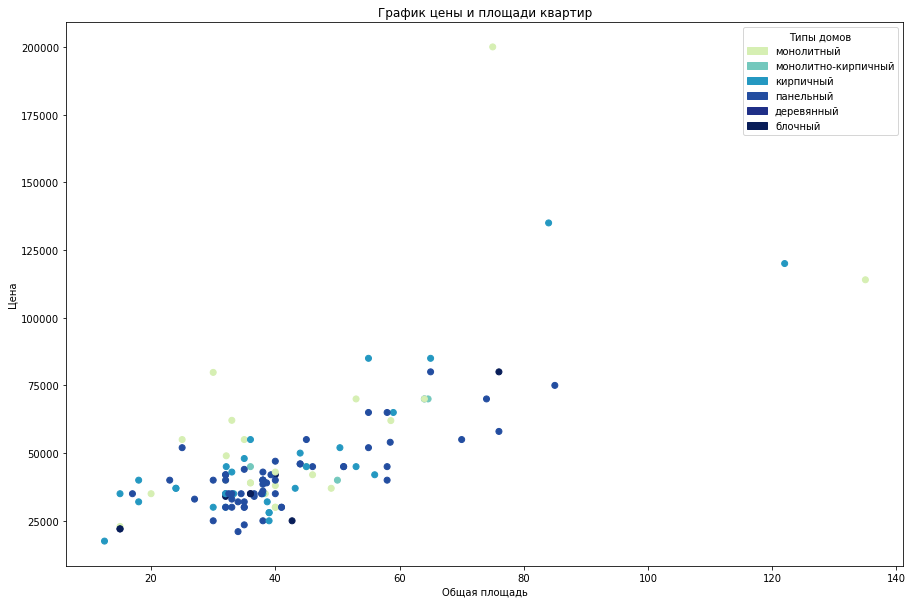

In [64]:
#Фильтруем квартиры со слишком большой ценой аренды, чтобы на графике были более различимы точки-квартиры
data = df_to_work.drop(['Местоположение', 'Координаты'], axis=1)
data['Общая площадь'] = data['Общая площадь'].fillna(data['Общая площадь'].mean())
data['Цена'] = data['Цена'].fillna(data['Цена'].mean())
data = data[data['Цена'] < 300000]
data = pd.DataFrame({'Цена': data['Цена'], 'Общая площадь': data['Общая площадь'], 'Тип дома': data['Тип дома']})

# Определение цветов для каждого типа дома
colors = {'монолитный': cm.YlGnBu(0.2), 'монолитно-кирпичный': cm.YlGnBu(0.4),
          'кирпичный': cm.YlGnBu(0.6), 'панельный': cm.YlGnBu(0.8), 'деревянный': cm.YlGnBu(0.9), 'блочный': cm.YlGnBu(1.0)}

sq = data['Общая площадь'].values.reshape(data['Общая площадь'].shape[0])
pr = data['Цена'].values.reshape(data['Цена'].shape[0])
c=data['Тип дома'].map(colors)

plt.figure(figsize=(15, 10))
plt.scatter(sq, pr, c=c)

legend_labels = [key for key in colors.keys()]
legend_handles = [mpatches.Patch(color=colors[key], label=key) for key in legend_labels]
plt.legend(handles=legend_handles, title='Типы домов', loc='upper right')

plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('График цены и площади квартир')

plt.show()

Вернемся к задаче предсказания цены. Мне кажется основная проблема низкой точности модели заключается в том, что мы одинакого прайсим все квартиры, однако следовало бы разделить их на типы по количеству комнат. Сделаем это.

In [65]:
grouped = df_to_work.groupby('Комнат')
for rooms, group in grouped:
    print("Комнат:", rooms)
    print(len(group))
    print()

Комнат: 0.5
9

Комнат: 1.0
75

Комнат: 2.0
28

Комнат: 3.0
11

Комнат: 4.0
1

Комнат: 9.0
1



Как видим, самая большая группа - однокомнатные квартиры. Попробуем решить задачу их прайсинга отдельно.

In [66]:
single_room_data = grouped.get_group(1)

df_1 = single_room_data.copy()
df_1 = df_1.drop(['Местоположение', 'Координаты'], axis=1)

url = "http://gis-lab.info/data/mos-adm/mo.geojson"
response = requests.get(url)
mo_geojson = response.json()

adm_moscow = gpd.GeoDataFrame.from_features(mo_geojson["features"])
gdf = gpd.GeoDataFrame(df_1, geometry=gpd.points_from_xy(df_1['долгота'], df_1['широта']))

merged = gpd.sjoin(gdf, adm_moscow, op='within')

df_1['Район'] = merged['NAME']

df_1 = df_1.drop(['широта', 'долгота'], axis=1)
categorical_features = ['Тип дома', 'Парковка', 'Балкон', 'Санузел', 'Ремонт', 'Интернет и ТВ', 'Район']
df_1 = pd.get_dummies(df_1, columns=categorical_features, drop_first=True)
df_1['Грузовой лифт'] = df_1['Грузовой лифт'].fillna(0)
df_1['Пассажирский лифт'] = df_1['Пассажирский лифт'].fillna(0)
df_1 = df_1.fillna(df_1.mean())

X = df_1.drop('Цена', axis=1)
y = df_1['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

new_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=new_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE на тестовом наборе:", rmse)

/Users/tim17/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RMSE на тестовом наборе: 7435.4321780129285


Идея сработала, точность на данном датафрейме возросла так, что мы научились оценивать цену аренды однокомнатной квартиры с точностью около 7000 рублей. Теперь когда мы получили достаточно точную модель, сделаем ряд содержательных выводов и посмотрим, что при аренде однокмантаной квартиры больше всего влияет на цену. Для этого используем heatmap с логорифмической шкалой для лучшей контрастности.

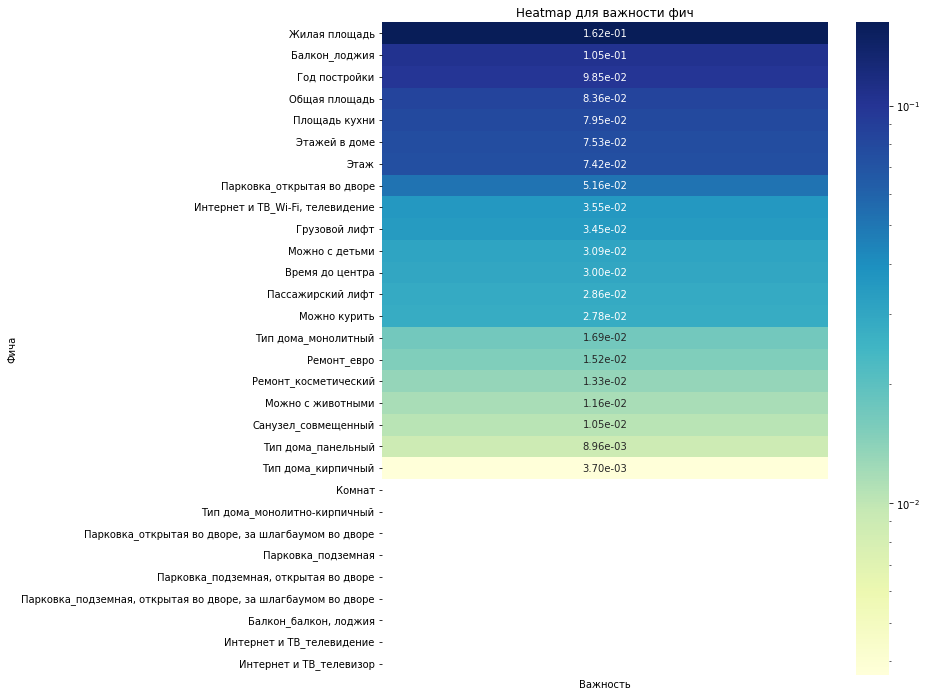

In [67]:
importances = best_model.feature_importances_
feature_names = X.columns

# Создание датафрейма с важностью фичей
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Сортировка по важности в порядке убывания, чтобы тепловая карта отображалось бы в порядке убывания важности фич. 
# Поскольку у нас слишком много районов, не будем их анализировать.
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False) 
feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].str.contains('Район')]

# Создание тепловой карты
min_value = feature_importance_df.loc[feature_importance_df['Importance'] > 0, 'Importance'].min()
plt.figure(figsize=(10, 12))
sns.heatmap(feature_importance_df.set_index('Feature'), cmap="YlGnBu", annot=True, fmt=".2e",
            norm=LogNorm(vmin=min_value, vmax=feature_importance_df['Importance'].max()),
            xticklabels=False, yticklabels=True)
plt.title("Heatmap для важности фич")
plt.xlabel("Важность")
plt.ylabel("Фича")
plt.show()

Неудевительно, что наиболее важным фактором является жилая площадь и площадь кухни. Также немаловажным является новизна дома, общее количество этажей (вероятно оно коррелирует с новизной) и наличие балкона. Интересным яявляется и весьма низкая значимость ремонта - она влияет на цену даже меньше, чем наличие вайфая в квартире. Важно сказать, что feature importance не учитывает положительная или отрицательная корреляция у фичи с таргетом (ценой).